In [1]:
import numpy as np
import galsim
import wfsim
import batoid
import matplotlib.pyplot as plt

In [2]:
class Star:
    
    def __init__(self) -> None:
        self.angle = None
        self.centroid = None
        self.flux = None
        self.T = None
        self.image = None
        self.stamp_size = 160
        
    @property
    def stamp(self) -> np.ndarray:
        w0 = self.stamp_size // 2
        w1 = self.stamp_size - w0
        x, y = self.centroid
        return self.image[y-w0:y+w1, x-w0:x+w1].copy()
    
    
class Pair:
    
    def __init__(self) -> None:
        self.chip = None
        self.background = None
        self.intra = Star()
        self.extra = Star()
        
        
class PairSimulator:
    
    def __init__(
        self,
        band: str = "r",
        obs: dict = None,
        atm_kwargs: dict = None,
        atm: bool = True,
        seed: int = 0,
        stamp_size: int = 160,
    ) -> None:        
        # load the bandpass and fiducial telescope
        self.bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type='nm')
        self.telescope0 = batoid.Optic.fromYaml(f"LSST_{band}.yaml")
        self.telescope = self.telescope0
        
        # set some observational parameters
        obs0 = {
            'zenith': 30 * galsim.degrees,
            'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
            'wavelength': self.bandpass.effective_wavelength,
            'exptime': 15.0,  # seconds
            'temperature': 293.,  # Kelvin
            'pressure': 69.,  #kPa
            'H2O_pressure': 1.0  #kPa
        }
        obs = {} if obs is None else obs
        self.obs = obs0 | obs

        # set atmospheric parameters
        atm_kwargs0 = {
            'screen_size': 819.2,
            'screen_scale': 0.1,
            'nproc': 6  # create screens in parallel using this many CPUs
        }
        atm_kwargs = {} if atm_kwargs is None else atm_kwargs
        self.atm_kwargs = atm_kwargs0 | atm_kwargs
        
        # set the seed
        self.set_seed(seed)
        
        # create the simulator
        self.simulator = wfsim.SimpleSimulator(
            self.obs,
            self.atm_kwargs,
            self.telescope0,
            self.bandpass,
            atm=atm,
            name="R00_SW0",
            rng=self.rng,
        )
        
        # save the stamp size
        self.stamp_size = stamp_size
        
        
    def set_seed(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)
        
        
    def set_chip(self, name: str) -> None:
        self.simulator.set_name(name)
        
        
    def set_zernikes(self, zernikes: np.ndarray) -> None:
        """Zernikes, in microns, starting with Noll index 4."""
        
        R_outer = self.telescope0.pupilSize / 2
        R_inner = R_outer * self.telescope0.pupilObscuration
        phase = batoid.Zernike(
            -np.pad(zernikes, pad_width=(4,0), mode='constant') * 1e-6,
            R_outer=R_outer,
            R_inner=R_inner,
        )
        perturbed = batoid.CompoundOptic(
                (
                    batoid.optic.OPDScreen(
                        batoid.Plane(),
                        phase,
                        name="PhaseScreen",
                        obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                        coordSys=self.telescope0.stopSurface.coordSys
                    ),
                    *self.telescope0.items,
                ),
                name="PerturbedLSST",
                backDist=self.telescope0.backDist,
                pupilSize=self.telescope0.pupilSize,
                inMedium=self.telescope0.inMedium,
                stopSurface=self.telescope0.stopSurface,
                sphereRadius=self.telescope0.sphereRadius,
                pupilObscuration=self.telescope0.pupilObscuration,
        )
        
        self.telescope = perturbed
        
    
    def get_opd(self, chip: str) -> np.ndarray:
        
        # where to evaluate OPD for each chip
        chip_locations = {
            # bottom left
            "R00": (-0.02075, -0.02075),
            # top left
            "R40": (-0.02075, +0.02075),
            # bottom right
            "R04": (+0.02075, -0.02075),
            # top right
            "R44": (+0.02075, +0.02075),
        }
        
        # get the OPD from batoid 
        opd = batoid.zernike(
            self.telescope,
            *chip_locations[chip],
            1e-6, # reference wavelength = 1 micron
            jmax=22,
            eps=self.telescope.pupilObscuration,
        ) - batoid.zernike(
            self.telescope0,
            *chip_locations[chip],
            1e-6, # reference wavelength = 1 micron
            jmax=22,
            eps=self.telescope0.pupilObscuration,
        )
        
        return opd[4:]
    
        
    def _simulate_star(
        self,
        angle: list,
        flux: int,
        T: float,
        background: float,
        chip: str,
        intra: bool,
    ) -> Star:
        # create the star
        star = Star()
        star.flux = int(flux)
        star.T = float(T)
        
        # create the star SED
        sed = wfsim.BBSED(star.T)
        
        # calculate pixel variance of background
        variance = background ** 2
        
        # set the telescope
        offset = -0.0015 if intra else +0.0015
        self.simulator.telescope = self.telescope.withGloballyShiftedOptic("Detector", [0, 0, offset])
        
        # set the CCD to simulate
        name = f"{chip}_SW{int(intra)}"
        self.simulator.set_name(name)
        
        # if no angle provided, random sample position
        if angle is None:
            """
            bounds = self.simulator.get_bounds()
            bounds[[0, 1], np.abs(bounds).argmax(axis=1)] *= 0.8
            bounds[[0, 1], np.abs(bounds).argmin(axis=1)] *= 1.2
            x = self.rng.uniform(*bounds[0])
            y = self.rng.uniform(*bounds[1])
            star.angle = np.rad2deg([x, y])
            """
            # calculate the bounds on the x and y angles
            bounds = self.simulator.image.bounds
            bounds = 0.9 * np.array([[bounds.xmin, bounds.ymin], [bounds.xmax, bounds.ymax]])
            xmin, ymin = self.simulator.wcs.xyToradec(*bounds[0], galsim.degrees)
            xmax, ymax = self.simulator.wcs.xyToradec(*bounds[1], galsim.degrees)
            x = self.rng.uniform(xmin, xmax)
            y = self.rng.uniform(ymin, ymax)
            star.angle = np.array([x, y])
        else:
            star.angle = np.array(angle)
        
        # simulate the star
        self.simulator.add_star(*np.deg2rad(star.angle), sed, star.flux, self.rng)
        
        # add background
        self.simulator.add_background(variance, self.rng)
        
        # save the full image
        star.image = self.simulator.image.array.copy()
        
        # save the donut centroid
        x, y = self.simulator.wcs.radecToxy(*star.angle, galsim.degrees)
        x = int(x - self.simulator.image.bounds.xmin) # x in image coords
        y = int(y - self.simulator.image.bounds.ymin) # y in image coords
        star.centroid = np.array([x, y])
        
        return star
    
    
    def simulate(
        self,
        intra_angle: list,
        extra_angle: list,
        intra_flux: int = 1_000_000,
        extra_flux: int = 1_000_000,
        intra_T: float = 8_000,
        extra_T: float = 8_000,
        background: float = 10,
        chip: str = "R00",
    ) -> Pair:
        # save the pair metadata
        pair = Pair()
        pair.chip = chip
        pair.background = float(background)
        pair.opd = self.get_opd(pair.chip)
        
        # simulate the intrafocal star
        pair.intra = self._simulate_star(
            intra_angle,
            intra_flux,
            intra_T,
            pair.background,
            pair.chip,
            intra=True,
        )
        
        # simulate the extrafocal star
        pair.extra = self._simulate_star(
            extra_angle,
            extra_flux,
            extra_T,
            pair.background,
            pair.chip,
            intra=False,
        )
    
        return pair

In [3]:
simulator = PairSimulator(atm=True)

In [4]:
rng = np.random.default_rng(11)
x = 1/np.arange(4, 23)**2
x /= x.max()
zk_true = rng.normal(scale=x)

simulator.set_zernikes(zk_true)

In [5]:
pair = simulator.simulate(
    extra_angle = None,
    intra_angle = None,
    background = 0,
)

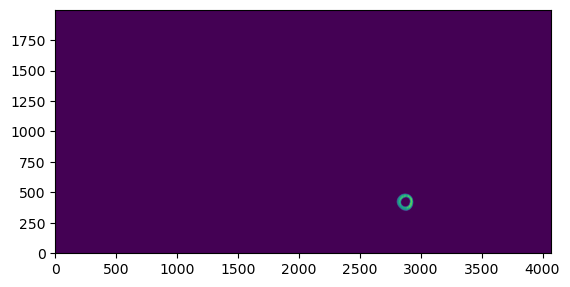

In [6]:
plt.imshow(pair.intra.image, origin="lower")

In [7]:
from lsst.ts.wep.wfEstimator import WfEstimator
from lsst.ts.wep.utility import getConfigDir, DefocalType

In [68]:
wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
wfEst.config(sizeInPix=160, algo="exp", debugLevel=1)

pairs = []
zk_est = []

dx = np.array([0, -1, 0, 0, 1]) * 150/3600
dy = np.array([0, 0, -1, 1, 0]) * 150/3600
atm_bool = [False, True, True, True, True]

for i, j, atm in zip(dx, dy, atm_bool):
    
    simulator.simulator.atm_bool = atm

    pair = simulator.simulate(
        extra_angle = [-1.190+i, -1.126+j],
        intra_angle = [-1.190+i, -1.255-j],
        background=0,
    )
    pairs.append(pair)
    
    wfEst.reset()
    wfEst.setImg(
        pair.intra.angle,
        DefocalType.Intra,
        image=pair.intra.stamp.copy(),
    )
    wfEst.setImg(
        pair.extra.angle,
        DefocalType.Extra,
        image=pair.extra.stamp.copy(),
    )
    zk_est.append(wfEst.calWfsErr() / 1e3)

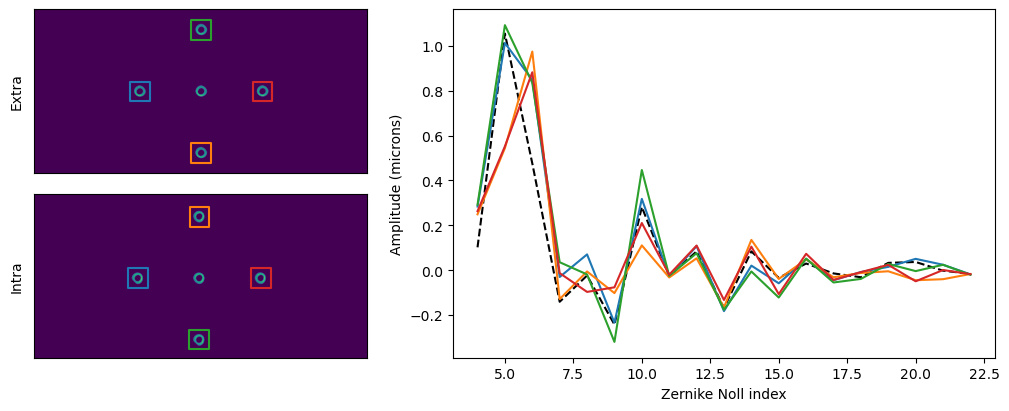

In [69]:
fig, axes = plt.subplot_mosaic(
    """
    aaccc
    bbccc
    """,
    figsize=(10, 4),
    constrained_layout=True,
)

img = pairs[0].extra.image.copy()
for i, pair in enumerate(pairs[1:]):
    img += pair.extra.image.copy()
    axes["a"].scatter(*pair.extra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["a"].imshow(img, origin="lower")
axes["a"].set(xticks=[], yticks=[], ylabel="Extra")

img = pairs[0].intra.image.copy()
for i, pair in enumerate(pairs[1:]):
    img += pair.intra.image.copy()
    axes["b"].scatter(*pair.intra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["b"].imshow(img, origin="lower")
axes["b"].set(xticks=[], yticks=[], ylabel="Intra")

axes["c"].plot(np.arange(4, 23), zk_est[0], c="k", ls="--")
for zk in zk_est[1:]:
    axes["c"].plot(np.arange(4, 23), zk)
axes["c"].set(xlabel="Zernike Noll index", ylabel="Amplitude (microns)")

plt.show()

In [8]:
wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
wfEst.config(sizeInPix=160, algo="exp", debugLevel=1)

pairs = {
    "atm": [],
    "no atm": [],
}

zk_est = {
    "atm": [],
    "no atm": [],
}

simulator.simulator.atm_bool = True
simulator.set_seed(0)

for _ in range(10):
    
    pair = simulator.simulate(
        extra_angle = None,
        intra_angle = None,
        background=0,
    )
    pairs["atm"].append(pair)
    
    wfEst.reset()
    wfEst.setImg(
        pair.intra.angle,
        DefocalType.Intra,
        image=pair.intra.stamp.copy(),
    )
    wfEst.setImg(
        pair.extra.angle,
        DefocalType.Extra,
        image=pair.extra.stamp.copy(),
    )
    zk_est["atm"].append(wfEst.calWfsErr() / 1e3)
    
simulator.simulator.atm_bool = False
simulator.set_seed(0)

for pair in pairs["atm"]:
    
    pair = simulator.simulate(
        extra_angle = pair.extra.angle,
        intra_angle = pair.intra.angle,
        background=0,
    )
    pairs["no atm"].append(pair)
    
    wfEst.reset()
    wfEst.setImg(
        pair.intra.angle,
        DefocalType.Intra,
        image=pair.intra.stamp.copy(),
    )
    wfEst.setImg(
        pair.extra.angle,
        DefocalType.Extra,
        image=pair.extra.stamp.copy(),
    )
    zk_est["no atm"].append(wfEst.calWfsErr() / 1e3)
    
pairs["atm"] = np.array(pairs["atm"])
pairs["no atm"] = np.array(pairs["no atm"])
zk_est["atm"] = np.array(zk_est["atm"])
zk_est["no atm"] = np.array(zk_est["no atm"])

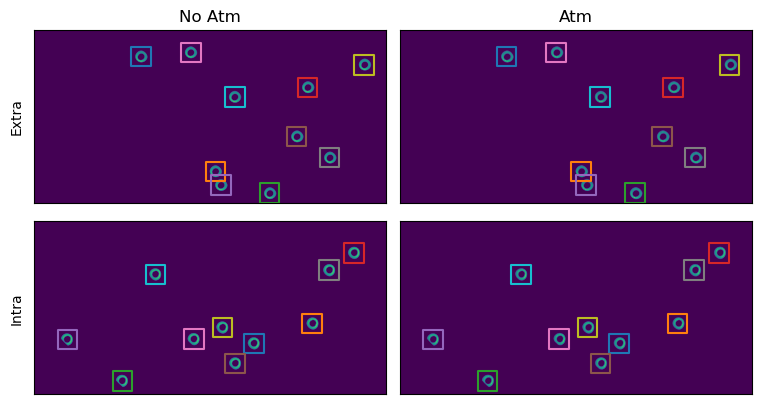

In [16]:
fig, axes = plt.subplot_mosaic(
    """
    aacc
    bbdd
    """,
    figsize=(7.5, 4),
    constrained_layout=True,
)

img = np.zeros_like(pairs["no atm"][0].extra.image)
for i, pair in enumerate(pairs["no atm"]):
    img += pair.extra.image.copy()
    axes["a"].scatter(*pair.extra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["a"].imshow(img, origin="lower")
axes["a"].set(xticks=[], yticks=[], ylabel="Extra", title="No Atm")

img = np.zeros_like(pairs["no atm"][0].intra.image)
for i, pair in enumerate(pairs["no atm"]):
    img += pair.intra.image.copy()
    axes["b"].scatter(*pair.intra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["b"].imshow(img, origin="lower")
axes["b"].set(xticks=[], yticks=[], ylabel="Intra")

img = np.zeros_like(pairs["atm"][0].extra.image)
for i, pair in enumerate(pairs["atm"]):
    img += pair.extra.image.copy()
    axes["c"].scatter(*pair.extra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["c"].imshow(img, origin="lower")
axes["c"].set(xticks=[], yticks=[], title="Atm")

img = np.zeros_like(pairs["atm"][0].intra.image)
for i, pair in enumerate(pairs["atm"]):
    img += pair.intra.image.copy()
    axes["d"].scatter(*pair.intra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["d"].imshow(img, origin="lower")
axes["d"].set(xticks=[], yticks=[])

plt.show()

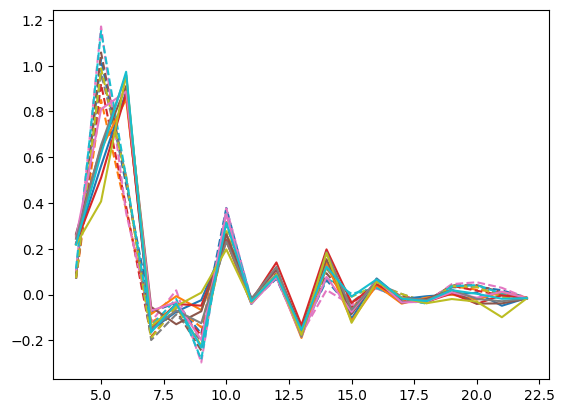

In [26]:
idx = [0, 1, 3, 5, 6, 7, 8, 9]
zk_noatm_mean = np.array(zk_est["no atm"])[idx].mean(axis=0)
zk_atm_mean = np.array(zk_est["atm"])[idx].mean(axis=0)

#plt.plot(np.arange(4, 23), zk_noatm_mean, c="k", ls="--")
#plt.plot(np.arange(4, 23), zk_atm_mean)

for i in idx:
    plt.plot(np.arange(4, 23), zk_est["no atm"][i], c=f"C{i}", ls="--")
    
for i in idx:
    plt.plot(np.arange(4, 23), zk_est["atm"][i], c=f"C{i}")

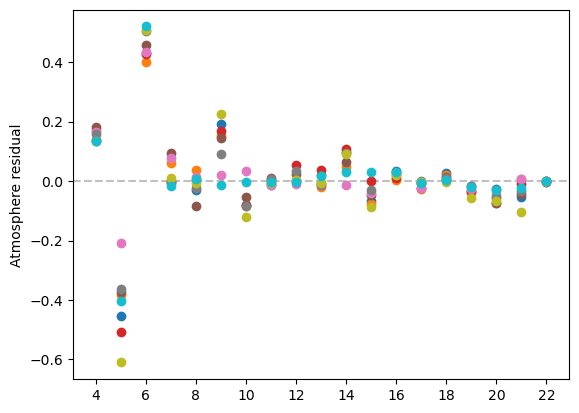

In [34]:
for i in idx:
    plt.scatter(np.arange(4, 23), zk_est["atm"][i] - zk_noatm_mean, c=f"C{i}")
    
plt.axhline(0, ls="--", c="silver", zorder=0)
plt.xticks(np.arange(4, 23, 2))
plt.ylabel("Atmosphere residual")

plt.show()

Text(0, 0.5, 'Atmosphere residual')

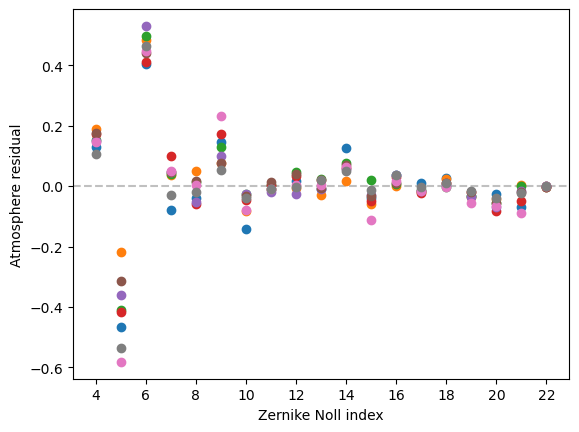

In [38]:
for zk in (np.array(zk_est["atm"]) - np.array(zk_est["no atm"]))[idx]:
    plt.scatter(np.arange(4, 23), zk)
plt.xticks(np.arange(4, 23, 2))
plt.axhline(0, ls="--", c="silver", zorder=0)
plt.xlabel("Zernike Noll index")
plt.ylabel("Atmosphere residual")

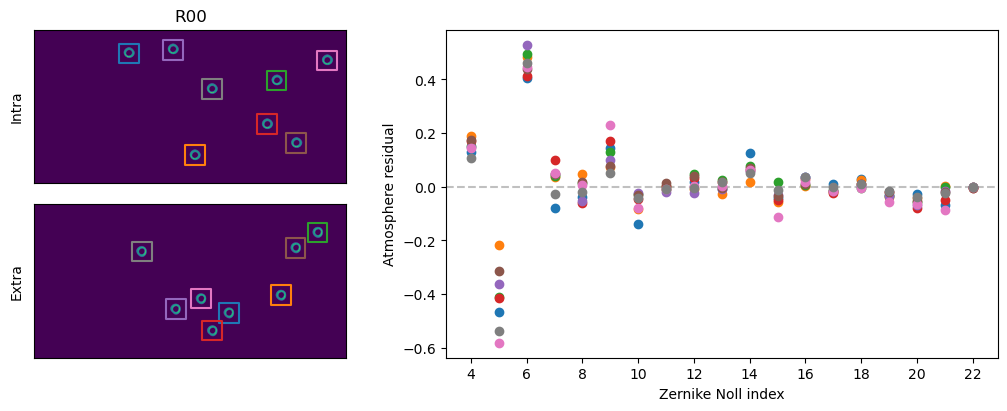

In [44]:
fig, axes = plt.subplot_mosaic(
    """
    aaccc
    bbccc
    """,
    figsize=(10, 4),
    constrained_layout=True,
)

idx = [0, 1, 3, 5, 6, 7, 8, 9]

img = np.zeros_like(pairs["atm"][0].extra.image)
for i, pair in enumerate(pairs["atm"][idx]):
    img += pair.extra.image.copy()
    axes["a"].scatter(*pair.extra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["a"].imshow(img, origin="lower")
axes["a"].set(xticks=[], yticks=[], ylabel="Intra", title="R00")

img = np.zeros_like(pairs["atm"][0].intra.image)
for i, pair in enumerate(pairs["atm"][idx]):
    img += pair.intra.image.copy()
    axes["b"].scatter(*pair.intra.centroid, facecolors="none", edgecolors=f"C{i}", marker="s", s=200, lw=1.5)
axes["b"].imshow(img, origin="lower")
axes["b"].set(xticks=[], yticks=[], ylabel="Extra")

for zk in (zk_est["atm"] - zk_est["no atm"])[idx]:
    axes["c"].scatter(np.arange(4, 23), zk)
axes["c"].axhline(0, ls="--", c="silver", zorder=0)
axes["c"].set(
    xticks=np.arange(4, 23, 2),
    xlabel="Zernike Noll index",
    ylabel="Atmosphere residual",
)

plt.show()

This one had no atmosphere

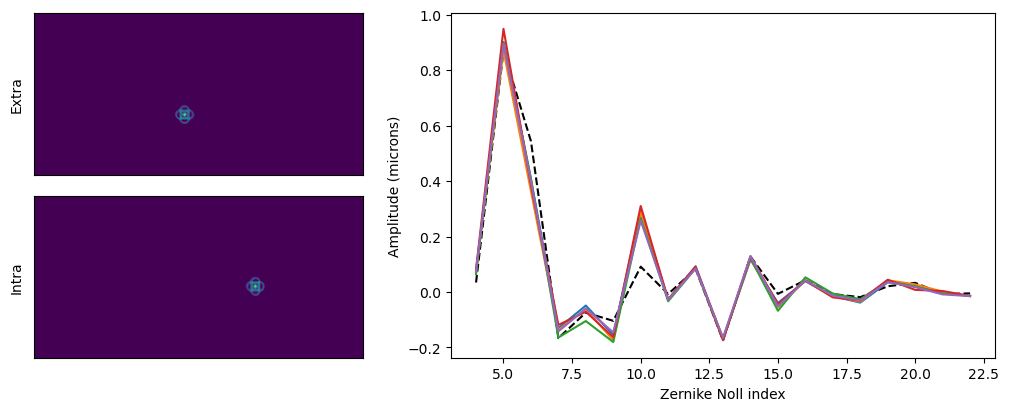

In [31]:
fig, axes = plt.subplot_mosaic(
    """
    aaccc
    bbccc
    """,
    figsize=(10, 4),
    constrained_layout=True,
)

img = pairs2[0].extra.image.copy()
for pair in pairs2[1:]:
    img += pair.extra.image.copy()
axes["a"].imshow(img, origin="lower")
axes["a"].set(xticks=[], yticks=[], ylabel="Extra")

img = pairs2[0].intra.image.copy()
for pair in pairs2[1:]:
    img += pair.intra.image.copy()
axes["b"].imshow(img, origin="lower")
axes["b"].set(xticks=[], yticks=[], ylabel="Intra")

axes["c"].plot(np.arange(4, 23), pair.opd, c="k", ls="--")
for zk in zk_est2:
    axes["c"].plot(np.arange(4, 23), zk)
axes["c"].set(xlabel="Zernike Noll index", ylabel="Amplitude (microns)")

plt.show()

This one has an atmosphere

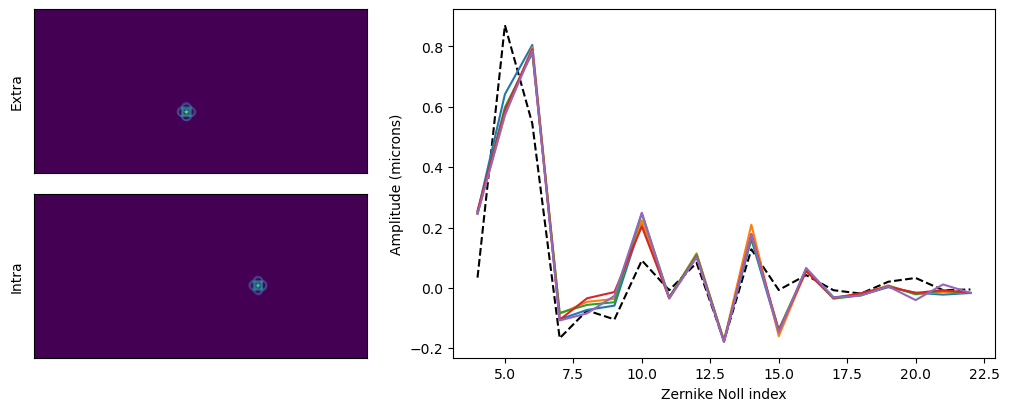

In [12]:
fig, axes = plt.subplot_mosaic(
    """
    aaccc
    bbccc
    """,
    figsize=(10, 4),
    constrained_layout=True,
)

img = pairs[0].extra.image.copy()
for pair in pairs[1:]:
    img += pair.extra.image.copy()
axes["a"].imshow(img, origin="lower")
axes["a"].set(xticks=[], yticks=[], ylabel="Extra")

img = pairs[0].intra.image.copy()
for pair in pairs[1:]:
    img += pair.intra.image.copy()
axes["b"].imshow(img, origin="lower")
axes["b"].set(xticks=[], yticks=[], ylabel="Intra")

axes["c"].plot(np.arange(4, 23), pair.opd, c="k", ls="--")
for zk in zk_est:
    axes["c"].plot(np.arange(4, 23), zk)
axes["c"].set(xlabel="Zernike Noll index", ylabel="Amplitude (microns)")

plt.show()

In [14]:
from lsst.ts.wep.wfEstimator import WfEstimator
from lsst.ts.wep.utility import getConfigDir, DefocalType
from scipy.ndimage import binary_dilation

In [15]:
outerLoopIter = 14

# create a WfEstimator
wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
wfEst.config(sizeInPix=160, algo="exp", debugLevel=1)

# get the Zernike basis & gradients
zk, dzkdx, dzkdy = wfEst.algo._zernikeBasisCache()

# normalize the gradients to aperture radius
R = wfEst.algo._inst.apertureDiameter / 2.0
dzkdx = dzkdx / R
dzkdy = dzkdy / R

# construct the pupil mask
eps = wfEst.algo.getObsOfZernikes()
xSensor, ySensor = wfEst.algo._inst.getSensorCoor()
mask = (np.sqrt(xSensor**2 + ySensor**2) > eps) & (np.sqrt(xSensor**2 + ySensor**2) < 1)

# mask the Zernikes
zk = zk * mask
dzkdx = dzkdx * mask
dzkdy = dzkdy * mask

# calculate dOmega
sensorFactor = wfEst.algo._inst.getSensorFactor()
aperturePixelSize = (
    wfEst.algo._inst.apertureDiameter * sensorFactor / wfEst.algo._inst.dimOfDonutImg
)
dOmega = aperturePixelSize**2

# and Delta z = f(f-l)/l
# where f = focal length; l = defocus distance of image planes
deltaZ = (
    wfEst.algo._inst.focalLength
    * (wfEst.algo._inst.focalLength - wfEst.algo._inst.defocalDisOffsetInM)
    / wfEst.algo._inst.defocalDisOffsetInM
)

# run the algorithm
wfEst.setImg(
    pair.intra.angle,
    DefocalType.Intra,
    image=pair.intra.stamp.copy(),
)
wfEst.setImg(
    pair.extra.angle,
    DefocalType.Extra,
    image=pair.extra.stamp.copy(),
)
zk_tswep = wfEst.calWfsErr()
history = wfEst.algo.getHistory()[outerLoopIter]

# make the variance map
pixel_sum_1 = history["compI1"][history["pupilMask"] > 0].sum()
pixel_sum_2 = history["compI2"][history["pupilMask"] > 0].sum()
variance_map = (
    (pair.background ** 2 + history["compI1"]) / pixel_sum_1**2 +
    (pair.background ** 2 + history["compI2"]) / pixel_sum_2**2
) / (4 * deltaZ**2)
variance_map *= history["pupilMask"]

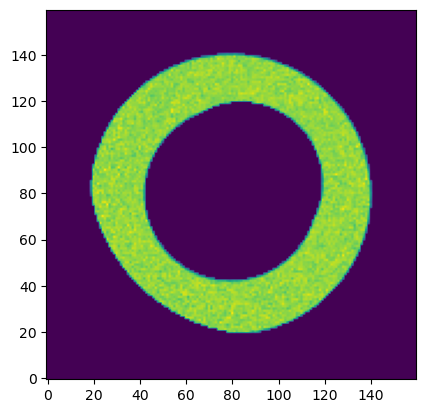

In [16]:
# pull out the compensated images from the final iteration
I1 = history["maskedI1"].copy() # intra
I2 = history["maskedI2"].copy() # extra
vmap = variance_map.copy()

#i = -1
#I1[i:, i:] = 0
#I2[i:, i:] = 0
#vmap[i:, i:] = 0

#blend = np.pad(history["pupilMask"], 200)
#blend = np.roll(blend, int(30/np.sqrt(2)), 0)
#blend = np.roll(blend, int(30/np.sqrt(2)), 1)
#blend = binary_dilation(blend, iterations=3).astype(blend.dtype)
#blend_mask =  ~blend + 2
#blend_mask = blend_mask[200:-200, 200:-200]
#I1 *= blend_mask
#I2 *= blend_mask
#vmap *= blend_mask

# Calculate the image gradient and mean image
gradI = (I2 - I1) / (2 * deltaZ)
I0 = (I2 + I1) / 2

# calculate F
F = np.einsum("jab,ab->j", zk, gradI) * dOmega

# and M
M = np.einsum("jab,kab,ab->jk", dzkdx, dzkdx, I0) * dOmega
M += np.einsum("jab,kab,ab->jk", dzkdy, dzkdy, I0) * dOmega

plt.imshow(vmap, origin="lower");

In [17]:
# estimate Zernikes (this is the same thing ts_wep does)
beta = np.linalg.lstsq(M, F, rcond=None)[0]

In [18]:
# calculate the covariance matrix
C = np.einsum("jab,kab,ab->jk", zk, zk, vmap, optimize="optimal") * dOmega**2

# perform Cholesky decomposition
L = np.linalg.cholesky(C)

# calculate Mtilde and Ftilde
Mt = np.linalg.solve(L, M)
Ft = np.linalg.solve(L, F)

# solve for beta tilde
betat = np.linalg.lstsq(Mt, Ft, rcond=None)[0]

Cbt = np.linalg.inv(Mt[3:, 3:].T @ Mt[3:, 3:])

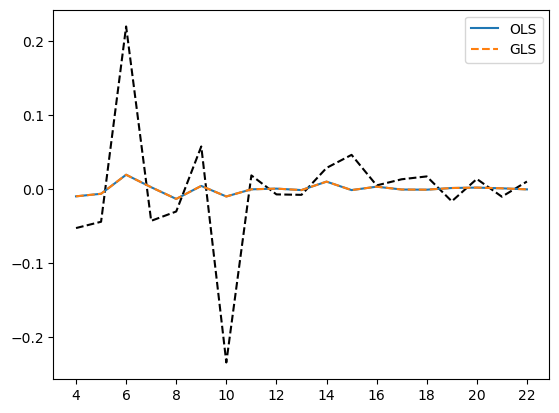

In [19]:
plt.plot(np.arange(4, 23), pair.opd - history["compZk"][3:]/1e3, c="k", ls="--")
plt.plot(np.arange(4, 23), beta[3:] * 1e6, label="OLS")
plt.plot(np.arange(4, 23), betat[3:] * 1e6, label="GLS", ls="--")
plt.xticks(np.arange(4, 23, 2))
plt.legend()
plt.show()

Text(0.5, 0, 'Noll index')

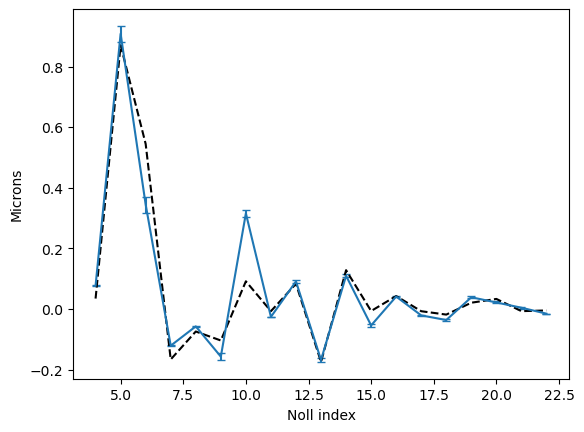

In [20]:
plt.errorbar(np.arange(4, 23), betat[3:]*1e6+history["compZk"][3:]/1e3, yerr=np.sqrt(np.diag(Cbt))*1e6, capsize=3)
plt.plot(np.arange(4, 23), pair.opd, c="k", ls="--")
plt.ylabel("Microns")
plt.xlabel("Noll index")